In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
from torchvision.datasets import Flickr30k
import numpy as np
import struct
from torch.utils.tensorboard import SummaryWriter


In [63]:
!pip -q install datasets pillow

In [64]:
import os, re, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from datasets import load_dataset
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [61]:
from datasets import load_dataset

CANDIDATES = [
    "AnyModal/flickr30k",         # train/validation/test splits + images
          # another mirrored dataset
]

dataset = None
last_err = None

print("📥 Téléchargement Flickr30k depuis Hugging Face...")

for name in CANDIDATES:
    try:
        print(" - Trying:", name)
        dataset = load_dataset(name)
        print("✅ Loaded:", name)
        break
    except Exception as e:
        print("   ❌ Failed:", name, "|", e)
        last_err = e

if dataset is None:
    raise RuntimeError(f"Impossible de charger Flickr30k. Dernière erreur: {last_err}")

print("Splits disponibles:", list(dataset.keys()))
print("Features train:", dataset[list(dataset.keys())[0]].features)


📥 Téléchargement Flickr30k depuis Hugging Face...
 - Trying: AnyModal/flickr30k


README.md:   0%|          | 0.00/762 [00:00<?, ?B/s]

data/train-00000-of-00009.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

data/train-00001-of-00009.parquet:   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00002-of-00009.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

data/train-00003-of-00009.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

data/train-00004-of-00009.parquet:   0%|          | 0.00/448M [00:00<?, ?B/s]

data/train-00005-of-00009.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

data/train-00006-of-00009.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

data/train-00007-of-00009.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

data/train-00008-of-00009.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/140M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Loaded: AnyModal/flickr30k
Splits disponibles: ['train', 'validation', 'test']
Features train: {'image': Image(mode=None, decode=True), 'alt_text': List(Value('string')), 'sentids': List(Value('string')), 'split': Value('string'), 'img_id': Value('string'), 'filename': Value('string'), 'original_alt_text': List(Value('string'))}


Keys: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text']
Caption: Two people with shaggy hair look at their hands while hanging out in the yard.
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>


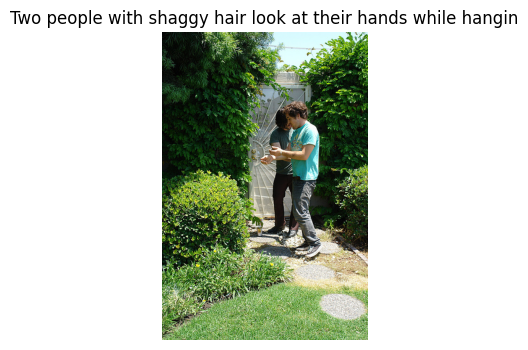

In [66]:
def get_caption(example):
    # essaie plusieurs formats
    if "alt_text" in example and example["alt_text"] is not None:
        # alt_text is a list of 5 captions per image
        if isinstance(example["alt_text"], list) and len(example["alt_text"]) > 0:
            return example["alt_text"][0]  # take the first caption
        return str(example["alt_text"])
    if "original_alt_text" in example and example["original_alt_text"] is not None:
        return example["original_alt_text"]
    raise KeyError(f"Aucun champ caption/captions/text trouvé. Keys={list(example.keys())}")
ex0 = dataset["train"][0]
print("Keys:", list(ex0.keys()))
print("Caption:", get_caption(ex0)[:150])
print("Image type:", type(ex0["image"]))

import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.imshow(ex0["image"])
plt.axis("off")
plt.title(get_caption(ex0)[:60])
plt.show()


In [67]:
from collections import Counter

PAD, BOS, EOS, UNK = "<pad>", "<bos>", "<eos>", "<unk>"
SPECIALS = [PAD, BOS, EOS, UNK]

def clean_text(s):
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9' ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

MAX_VOCAB_SAMPLES = 20000
MIN_FREQ = 3

counter = Counter()
n = min(len(dataset["train"]), MAX_VOCAB_SAMPLES)
for i in range(n):
    cap = clean_text(get_caption(dataset["train"][i]))
    counter.update(cap.split())

words = [w for w,c in counter.items() if c >= MIN_FREQ]
vocab = SPECIALS + sorted(words)

word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

vocab_size = len(vocab)
print("Vocab size:", vocab_size)
print("Exemples:", list(word2idx.items())[:10])

Vocab size: 3881
Exemples: [('<pad>', 0), ('<bos>', 1), ('<eos>', 2), ('<unk>', 3), ('10', 4), ('11', 5), ('12', 6), ('13', 7), ('15', 8), ('2', 9)]


In [68]:
MAX_LEN = 20

def tokenize(sentence):
    sentence = clean_text(sentence)
    ids = [word2idx[BOS]]
    for w in sentence.split():
        ids.append(word2idx.get(w, word2idx[UNK]))
    ids.append(word2idx[EOS])

    # truncate
    if len(ids) > MAX_LEN:
        ids = ids[:MAX_LEN]
        ids[-1] = word2idx[EOS]

    # pad
    ids = ids + [word2idx[PAD]] * (MAX_LEN - len(ids))
    return ids

def untokenize(ids):
    words = []
    for t in ids:
        w = idx2word[int(t)]
        if w == EOS:
            break
        if w not in [PAD, BOS]:
            words.append(w)
    return " ".join(words)

print(tokenize("A dog runs in the grass")[:12])

[1, 19, 1027, 2814, 1690, 3452, 1480, 2, 0, 0, 0, 0]


In [69]:
from torch.utils.data import random_split

img_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

class CaptionDS(Dataset):
    def __init__(self, hf_ds, max_items=None):
        self.ds = hf_ds
        self.max_items = max_items

    def __len__(self):
        return len(self.ds) if self.max_items is None else min(len(self.ds), self.max_items)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = img_tfms(ex["image"])
        cap = torch.tensor(tokenize(get_caption(ex)), dtype=torch.long)
        return img, cap

TOTAL_MAX = None  
base_ds = CaptionDS(dataset["train"], max_items=TOTAL_MAX)

# Split 90/10
n_total = len(base_ds)
n_val = int(0.1 * n_total)
n_train = n_total - n_val

train_ds, val_ds = random_split(
    base_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

xb, yb = next(iter(train_loader))
print("Train size:", len(train_ds), "Val size:", len(val_ds))
print("Images:", xb.shape, "Captions:", yb.shape)
print("Ex caption:", untokenize(yb[0].tolist()))


Train size: 26100 Val size: 2900
Images: torch.Size([32, 3, 224, 224]) Captions: torch.Size([32, 20])
Ex caption: a person wearing a gray shirt puts on a white apron


In [70]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# enlever avgpool + fc
cnn = nn.Sequential(*list(resnet.children())[:-2]).to(device)

for p in cnn.parameters():
    p.requires_grad = False
cnn.eval()

with torch.no_grad():
    feats = cnn(xb.to(device))
print("CNN feats:", feats.shape)  

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


CNN feats: torch.Size([32, 2048, 7, 7])


In [75]:
print(cnn)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [76]:
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
class Attention(nn.Module):
    def __init__(self, feature_dim=2048, hidden_dim=512, attn_dim=256):
        super().__init__()
        self.Wf = nn.Linear(feature_dim, attn_dim)
        self.Wh = nn.Linear(hidden_dim, attn_dim)
        self.v  = nn.Linear(attn_dim, 1)

    def forward(self, features, hidden):
        f = self.Wf(features)                
        h = self.Wh(hidden).unsqueeze(1)     
        e = torch.tanh(f + h)               
        scores = self.v(e).squeeze(-1)        
        alpha = torch.softmax(scores, dim=1)  
        context = (alpha.unsqueeze(-1) * features).sum(dim=1)  
        return context, alpha

In [72]:
class CaptionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, feature_dim=2048, attn_dim=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attn = Attention(feature_dim=feature_dim, hidden_dim=hidden_dim, attn_dim=attn_dim)

        self.lstm = nn.LSTMCell(embed_dim + feature_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, features, captions):
        """
        features: (B,N,F)
        captions: (B,T)
        returns logits: (B,T-1,V), attn_maps: (B,T-1,N)
        """
        B, T = captions.shape
        h = torch.zeros(B, self.hidden_dim, device=captions.device)
        c = torch.zeros(B, self.hidden_dim, device=captions.device)

        logits_list = []
        attn_list = []

        for t in range(T-1):
            token_t = captions[:, t]                
            emb_t = self.embedding(token_t)          
            context, alpha = self.attn(features, h)  

            lstm_in = torch.cat([emb_t, context], dim=1) 
            h, c = self.lstm(lstm_in, (h, c))          

            out = self.fc(h)                             
            logits_list.append(out.unsqueeze(1))
            attn_list.append(alpha.unsqueeze(1))

        logits = torch.cat(logits_list, dim=1) 
        attn_maps = torch.cat(attn_list, dim=1)  
        return logits, attn_maps

model = CaptionModel(vocab_size=vocab_size, embed_dim=256, hidden_dim=512).to(device)
print(model)

CaptionModel(
  (embedding): Embedding(3881, 256)
  (attn): Attention(
    (Wf): Linear(in_features=2048, out_features=256, bias=True)
    (Wh): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=True)
  )
  (lstm): LSTMCell(2304, 512)
  (fc): Linear(in_features=512, out_features=3881, bias=True)
)


In [73]:
lr = 5e-4
EPOCHS = 20
patience = 3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD])

best_val = float("inf")
best_path = "/kaggle/working/best_caption_model.pt"
pat_cnt = 0

def extract_features(images):
    with torch.no_grad():
        f = cnn(images)  
    B,C,H,W = f.shape
    f = f.permute(0,2,3,1).reshape(B, H*W, C)  
    return f

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    n = 0

    for images, captions in loader:
        images = images.to(device)
        captions = captions.to(device)

        feats = extract_features(images) 
        logits, _ = model(feats, captions)  
        targets = captions[:, 1:]           

        B,Tm1,V = logits.shape
        loss = criterion(logits.reshape(B*Tm1, V), targets.reshape(B*Tm1))

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        n += 1

    return total_loss / max(1,n)

for epoch in range(1, EPOCHS+1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    # save best + early stop
    if val_loss < best_val:
        best_val = val_loss
        pat_cnt = 0
        torch.save({
            "model_state": model.state_dict(),
            "word2idx": word2idx,
            "idx2word": idx2word,
            "vocab_size": vocab_size
        }, best_path)
        print("Saved best:", best_path)
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("Early stopping.")
            break

print("Best val loss:", best_val)

Epoch 01 | train_loss=3.7176 | val_loss=3.1838
Saved best: /kaggle/working/best_caption_model.pt
Epoch 02 | train_loss=2.9293 | val_loss=2.9227
Saved best: /kaggle/working/best_caption_model.pt
Epoch 03 | train_loss=2.6199 | val_loss=2.8227
Saved best: /kaggle/working/best_caption_model.pt
Epoch 04 | train_loss=2.3812 | val_loss=2.7756
Saved best: /kaggle/working/best_caption_model.pt
Epoch 05 | train_loss=2.1660 | val_loss=2.7778
Epoch 06 | train_loss=1.9592 | val_loss=2.7915
Epoch 07 | train_loss=1.7542 | val_loss=2.8420
Early stopping.
Best val loss: 2.7755557337960046


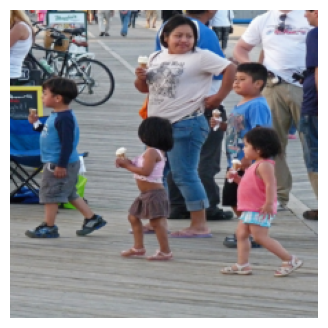

GT  : a group of kids and a person walk on the boardwalk eating ice cream cones
PRED: a group of kids including a person with a wheelchair are walking down a sidewalk


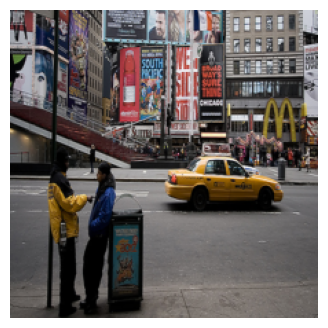

GT  : two people standing outside on the sidewalk one wearing a yellow jacket and the other wearing a blue
PRED: a person is walking down a street with a taxi in the background and a taxi taxi in the


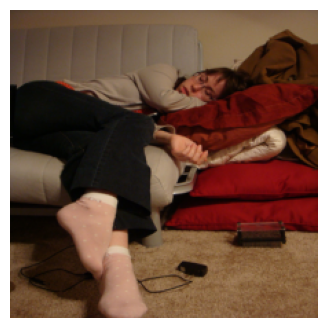

GT  : a person is sleeping on a sofa with red pillows and their head on a stack of pillows
PRED: a person wearing a black shirt and jeans is lying on the bed with a red blanket


In [74]:
@torch.no_grad()
def generate_caption_from_tensor(image_tensor, max_len=MAX_LEN):
    """
    image_tensor: torch.Tensor (3,224,224) déjà transformée
    """
    model.eval()
    image = image_tensor.unsqueeze(0).to(device)  
    feats = extract_features(image)              

    h = torch.zeros(1, model.hidden_dim, device=device)
    c = torch.zeros(1, model.hidden_dim, device=device)

    token = torch.tensor([word2idx[BOS]], device=device)
    out_words = []

    for _ in range(max_len - 1):
        emb = model.embedding(token)          
        context, _ = model.attn(feats, h)     
        lstm_in = torch.cat([emb, context], dim=1)
        h, c = model.lstm(lstm_in, (h, c))
        logits = model.fc(h)
        token = logits.argmax(dim=-1)

        w = idx2word[int(token.item())]
        if w == EOS:
            break
        if w not in [PAD, BOS]:
            out_words.append(w)

    return " ".join(out_words)

for i in [0, 1, 2]:
    img, cap_tok = val_ds[i]
    plt.figure(figsize=(4,4))
    plt.imshow(img.permute(1,2,0))
    plt.axis("off")
    plt.show()

    gt = untokenize(cap_tok.tolist())
    pred = generate_caption_from_tensor(img)

    print("GT  :", gt)
    print("PRED:", pred)
    print("="*60)
